In [1]:
import glam
import pandas as pd
import numpy as np
import os.path

In [2]:
import matplotlib.pyplot as plt

from scipy.stats import invgauss
import seaborn as sns
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
from scipy import stats
from scipy.stats.stats import pearsonr # Pearson's correlation
import statsmodels.api as sm

#import warnings
#warnings.filterwarnings('ignore')

In [3]:
np.random.seed(23) # from random.org

In [4]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [5]:
# For MacMini proper running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [7]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [8]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)

## Custom functions

In [9]:
def balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats):
    
    mean_rts_trials = np.zeros((value_tests.shape[0])) * np.nan
    choice_trials = np.zeros((value_tests.shape[0])) * np.nan
    DEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    AbsDEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    Ev_drifts_0_trials  = []
    Ev_drifts_1_trials = []

    n_trials, n_items = value_tests.shape

    running_idx_value = 0
    #we iterate for all the combinations of trials + gaze
    for trial in range(n_trials):
        
            # intialize the drifts
            evidence_drifts_0 = []
            evidence_drifts_1 = []

            #define value and gaze values for this particular trial
            value_trial =value_tests[trial]
            gaze_trial =gaze_tests[trial]
            
            Sim_value = value_trial
            Sim_gaze = gaze_trial
            
            Delta_E = np.zeros(n_repeats) * np.nan            
            AbsDelta_E = np.zeros(n_repeats) * np.nan
            rts = np.zeros(n_repeats) * np.nan
            choices = np.zeros(n_repeats) * np.nan
            trial_idx = np.zeros(n_repeats) * np.nan
            repeat_idx = np.zeros(n_repeats) * np.nan
            running_idx = 0
        
            for repeat in range(n_repeats):
                    

                    
                    Evi_0, Evi_1, choice, rt = glam.driftSim.simulate_trial_drift(parameters, value_trial, gaze_trial,
                                                boundary=boundary,
                                                error_weight=error_weight,
                                                error_range=error_range)
                    
                    Delta_E[running_idx] = Evi_1[-1] - Evi_0[-1]
                    AbsDelta_E[running_idx] = abs(Evi_0[-1] - Evi_1[-1])                        
                    rts[running_idx] = rt
                    choices[running_idx] = choice
                    trial_idx[running_idx] = trial
                    repeat_idx[running_idx] = repeat
                    # Add a new sequence of drift for this particular trial
                    evidence_drifts_0.append(Evi_0)
                    evidence_drifts_1.append(Evi_1)
                    
                    running_idx += 1
                    
               
            # Add the mean value for this parameters interation               
            mean_rts_trials [running_idx_value] = rts.mean()
            choice_trials [running_idx_value]= choices.mean() 
            DEv_trials [running_idx_value] = Delta_E.mean()
            AbsDEv_trials [running_idx_value]= AbsDelta_E.mean()
            Ev_drifts_0_trials.append(evidence_drifts_0)
            Ev_drifts_1_trials.append(evidence_drifts_1)
 
            running_idx_value += 1 

    return AbsDEv_trials,mean_rts_trials,Ev_drifts_0_trials,Ev_drifts_1_trials,choice_trials

In [10]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

    
        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [11]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [12]:
def add_difficulty(df):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    values = df[['LVal','RVal']].values
    values_sorted = np.sort(values, axis=1)
    difficulty = values_sorted[:, -1] - np.mean(values_sorted[:, :-1], axis=1)

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [13]:
def plot_DEv_Conf(data, ax=None, xlims=(0, 10), xlabel_skip=2,color1 = '#4F6A9A'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty(df)
    
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part', 'difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())
        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '--o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)

    #ax.set_ylim(2000, 3500)
    ax.set_xlabel('|ΔVal|')
    ax.set_ylabel( r'zΔ$\epsilon$ / zConfidence')
    ax.set_xticks(x[::xlabel_skip])
    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))



In [14]:
def add_difficulty_TotVal(df):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    difficulty = df[['TotVal']].values

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [15]:
def plot_DEv_Conf_TotVal(data, ax=None, xlims=(0, 10), xlabel_skip=2,color1 = '#4F6A9A'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty_TotVal(df)
    print ('Done with TotVal')
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part','difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())
        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '--o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)

    #ax.set_ylim(2000, 3500)
    ax.set_xlabel('|ΣVal|')
    ax.set_ylabel( r'zΔ$\epsilon$ / zConfidence')
    ax.set_xticks(x[::xlabel_skip])
    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))



## Define some parameters for the simulations


In [16]:
# Parameters for the simulations
boundary=1
error_weight=0.05

## Load data and GLAM structure (Like & Dislike)
Used binned data for simulation.

In [17]:
data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Like_NoBin_31.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

data2 = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Dislike_NoBin_Inv_31.csv'))
# Subset only necessary columns
data2 = data2[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

In [18]:
# Load data for FF2018 study 

# Like condition 

data_all0 = pd.read_csv('data/FF2018_data/DataFoodFramingNotebook_31.csv')
data_all0 = data_all0.drop(['Unnamed: 0'], axis=1)
data_all = data_all0.loc[data_all0['BlockCond'] == 1] # 1 = Like, 2 = Dislike

data_all=data_all.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

# Dislike condition

data_all2 = data_all0.loc[data_all0['BlockCond'] == 2] # 1 = Like, 2 = Dislike

data_all2=data_all2.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

## Load parameter estimates for participants

## Like condition

Use the parameter estimates from GLAM fit for Like, Binned data

In [19]:
sufix = '_Like_NoBin_NUTS_31'
glam_full = glam.GLAM(data)
glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))
glam_full.estimates = pd.DataFrame.from_dict(glam_full.estimates.item(0))
params_part = glam_full.estimates

In [20]:
params_part

,v_sd,v_mu,gamma_mu,tau_mu,t0,b,tau_sd,SNR,p_error,tau,gamma_sd,gamma,SNR_sd,v,s,SNR_mu
0,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,151.23,0.05,3.74,0.38,-0.11,35.54,0.000047,0.007843,164.29
1,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,137.71,0.05,4.30,0.38,0.29,35.54,0.000072,0.010344,164.29
2,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,141.48,0.05,2.59,0.38,-0.00,35.54,0.000058,0.008574,164.29
3,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,157.60,0.05,4.65,0.38,-0.10,35.54,0.000043,0.007178,164.29
4,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,96.58,0.05,4.22,0.38,-0.37,35.54,0.000080,0.007063,164.29
5,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,113.65,0.05,2.80,0.38,0.15,35.54,0.000059,0.008615,164.29
6,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,163.65,0.05,3.55,0.38,-0.00,35.54,0.000069,0.010656,164.29
7,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,150.49,0.05,3.29,0.38,-0.08,35.54,0.000045,0.007405,164.29
8,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,175.26,0.05,1.24,0.38,-0.71,35.54,0.000053,0.009622,164.29
9,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,137.66,0.05,4.77,0.38,-0.08,35.54,0.000048,0.007104,164.29


# Run drift simulations for selected values and parameters

#  1. Including gaze information in the simulation 

In [21]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_like_31_part.csv')):  
        data_simulation = pd.read_csv("results/simulations_evidence/DEvidence_simulations_like_31_part.csv")

In [22]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 0 # We DO want to use the gaze from the particpants

In [23]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_like_31_part.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    part_id = data_all['Part'].unique()
    
    for i in (data['subject'].unique()):    
        for k in range(0,repeat_extra) :
            PartData = data.loc[data['subject'] == i] # dataframe including participant GLAM data
            PartDataAll = data_all.loc[data_all['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))
        
    data_simulation =  pd.DataFrame()
    data_simulation["Part"] = Part_number
    data_simulation["LVal"] = LVal
    data_simulation["RVal"] = RVal
    data_simulation["AbsDVal"] = absDVal
    data_simulation["TotVal"] = TotVal
    data_simulation["AbsDEv"] = AbsDEvid
    data_simulation["RTsim"] = RT_sim
    data_simulation["Correct_sim"] = Correct_sim
    data_simulation["Choice_sim"] = Choice_sim
    data_simulation["Conf_human"] = Conf_human
    data_simulation["zConf_human"] = zConf_human
    
    data_simulation["zLVal"] = z_score1(data_simulation,'Part',"LVal")
    data_simulation["zRVal"] = z_score1(data_simulation,'Part',"RVal")
    data_simulation["zAbsDVal"] = z_score1(data_simulation,'Part',"AbsDVal")
    data_simulation["zTotVal"] = z_score1(data_simulation,'Part',"TotVal")
    data_simulation["zAbsDEv"] = z_score1(data_simulation,'Part',"AbsDEv")
    data_simulation["zRTsim"] = z_score1(data_simulation,'Part',"RTsim")

In [24]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_like_31_part.csv')):   
        data_simulation.to_csv("results/simulations_evidence/DEvidence_simulations_like_31_part.csv")

In [25]:
data_simulation

,Unnamed: 0,Part,LVal,RVal,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,0,1.10,0.95,0.15,2.05,0.562037,3114.0,1,0.0,80,0.582155,-0.898735,-1.237881,-0.988498,-1.497033,-0.587035,0.502240
1,1,0,2.00,1.70,0.30,3.70,0.240365,3815.0,1,0.0,78,0.432565,1.136137,0.457846,-0.570823,1.116834,-1.413819,1.168099
2,2,0,1.10,2.30,1.20,3.40,0.560002,1744.0,1,1.0,82,0.731746,-0.898735,1.814428,1.935228,0.641585,-0.592267,-0.799083
3,3,0,1.25,1.40,0.15,2.65,1.045098,2105.0,1,1.0,42,-2.260059,-0.559590,-0.220445,-0.988498,-0.546536,0.654559,-0.456179
4,4,0,2.00,2.30,0.30,4.30,0.218963,2945.0,1,1.0,70,-0.165796,1.136137,1.814428,-0.570823,2.067331,-1.468827,0.341712
5,5,0,1.70,1.85,0.15,3.55,0.893705,1781.0,1,1.0,74,0.133385,0.457846,0.796992,-0.988498,0.879210,0.265440,-0.763937
6,6,0,1.85,0.65,1.20,2.50,1.199453,3104.0,1,0.0,70,-0.165796,0.796992,-1.916172,1.935228,-0.784160,1.051293,0.492741
7,7,0,1.55,0.80,0.75,2.35,1.337536,1539.0,1,0.0,76,0.282975,0.118701,-1.577026,0.682203,-1.021784,1.406204,-0.993806
8,8,0,1.55,1.10,0.45,2.65,1.010269,1981.0,1,0.0,90,1.330107,0.118701,-0.898735,-0.153148,-0.546536,0.565040,-0.573963
9,9,0,1.10,2.00,0.90,3.10,0.254428,3251.0,1,1.0,54,-1.362518,-0.898735,1.136137,1.099878,0.166337,-1.377672,0.632372


Pearson's r = 0.08 p =  0.0


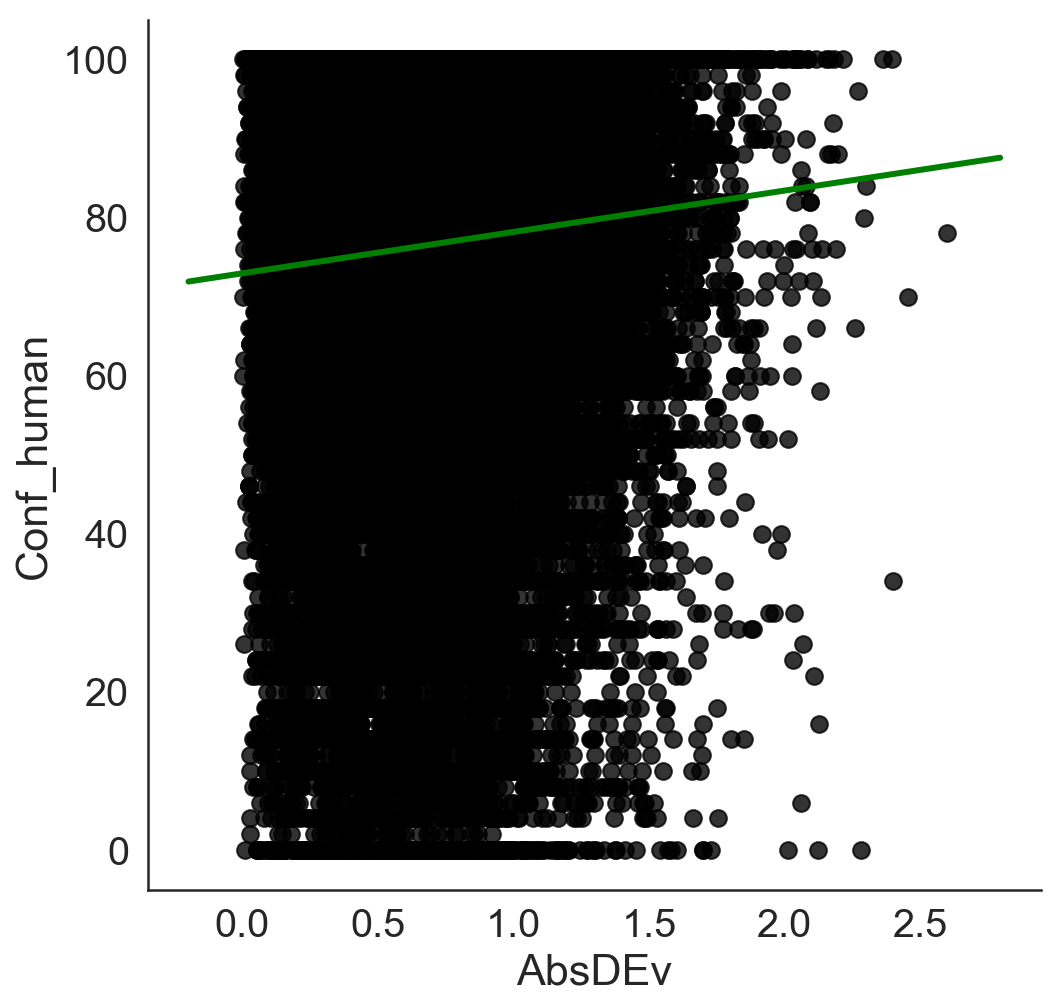

Pearson's r = 0.083 p =  0.0


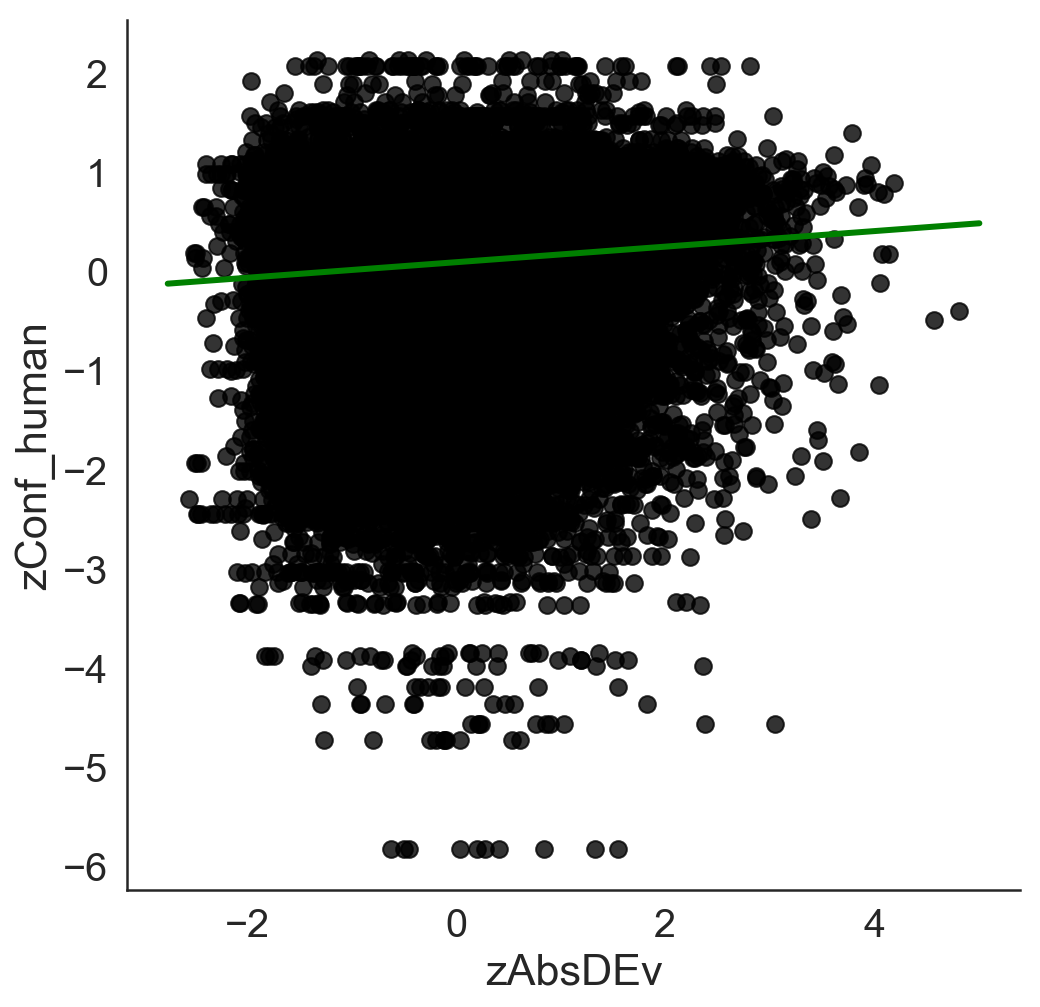

In [26]:
correl_plot(data_simulation,'AbsDEv', "AbsDEv",'Conf_human','Conf_human')
correl_plot(data_simulation,'zAbsDEv', "zAbsDEv",'zConf_human','zConf_human')

In [27]:
%%R -i data_simulation
d <- data_simulation

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 102100.6
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal + zRTsim, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal       zRTsim  
 -1.183e-15    1.604e-01    7.826e-02   -2.024e-01  

Degrees of Freedom: 37199 Total (i.e. Null);  37196 Residual
Null Deviance:	    37200 
Residual Deviance: 33840 	AIC: 102100


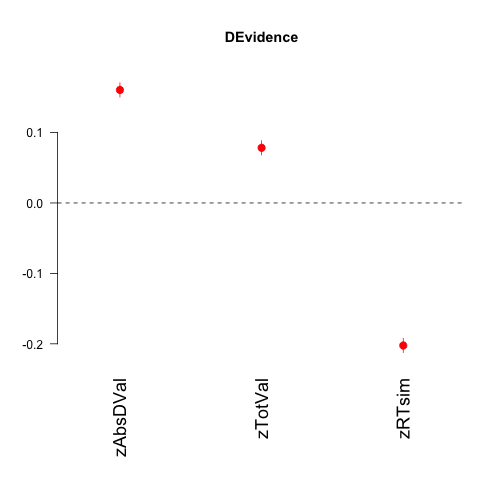

In [28]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

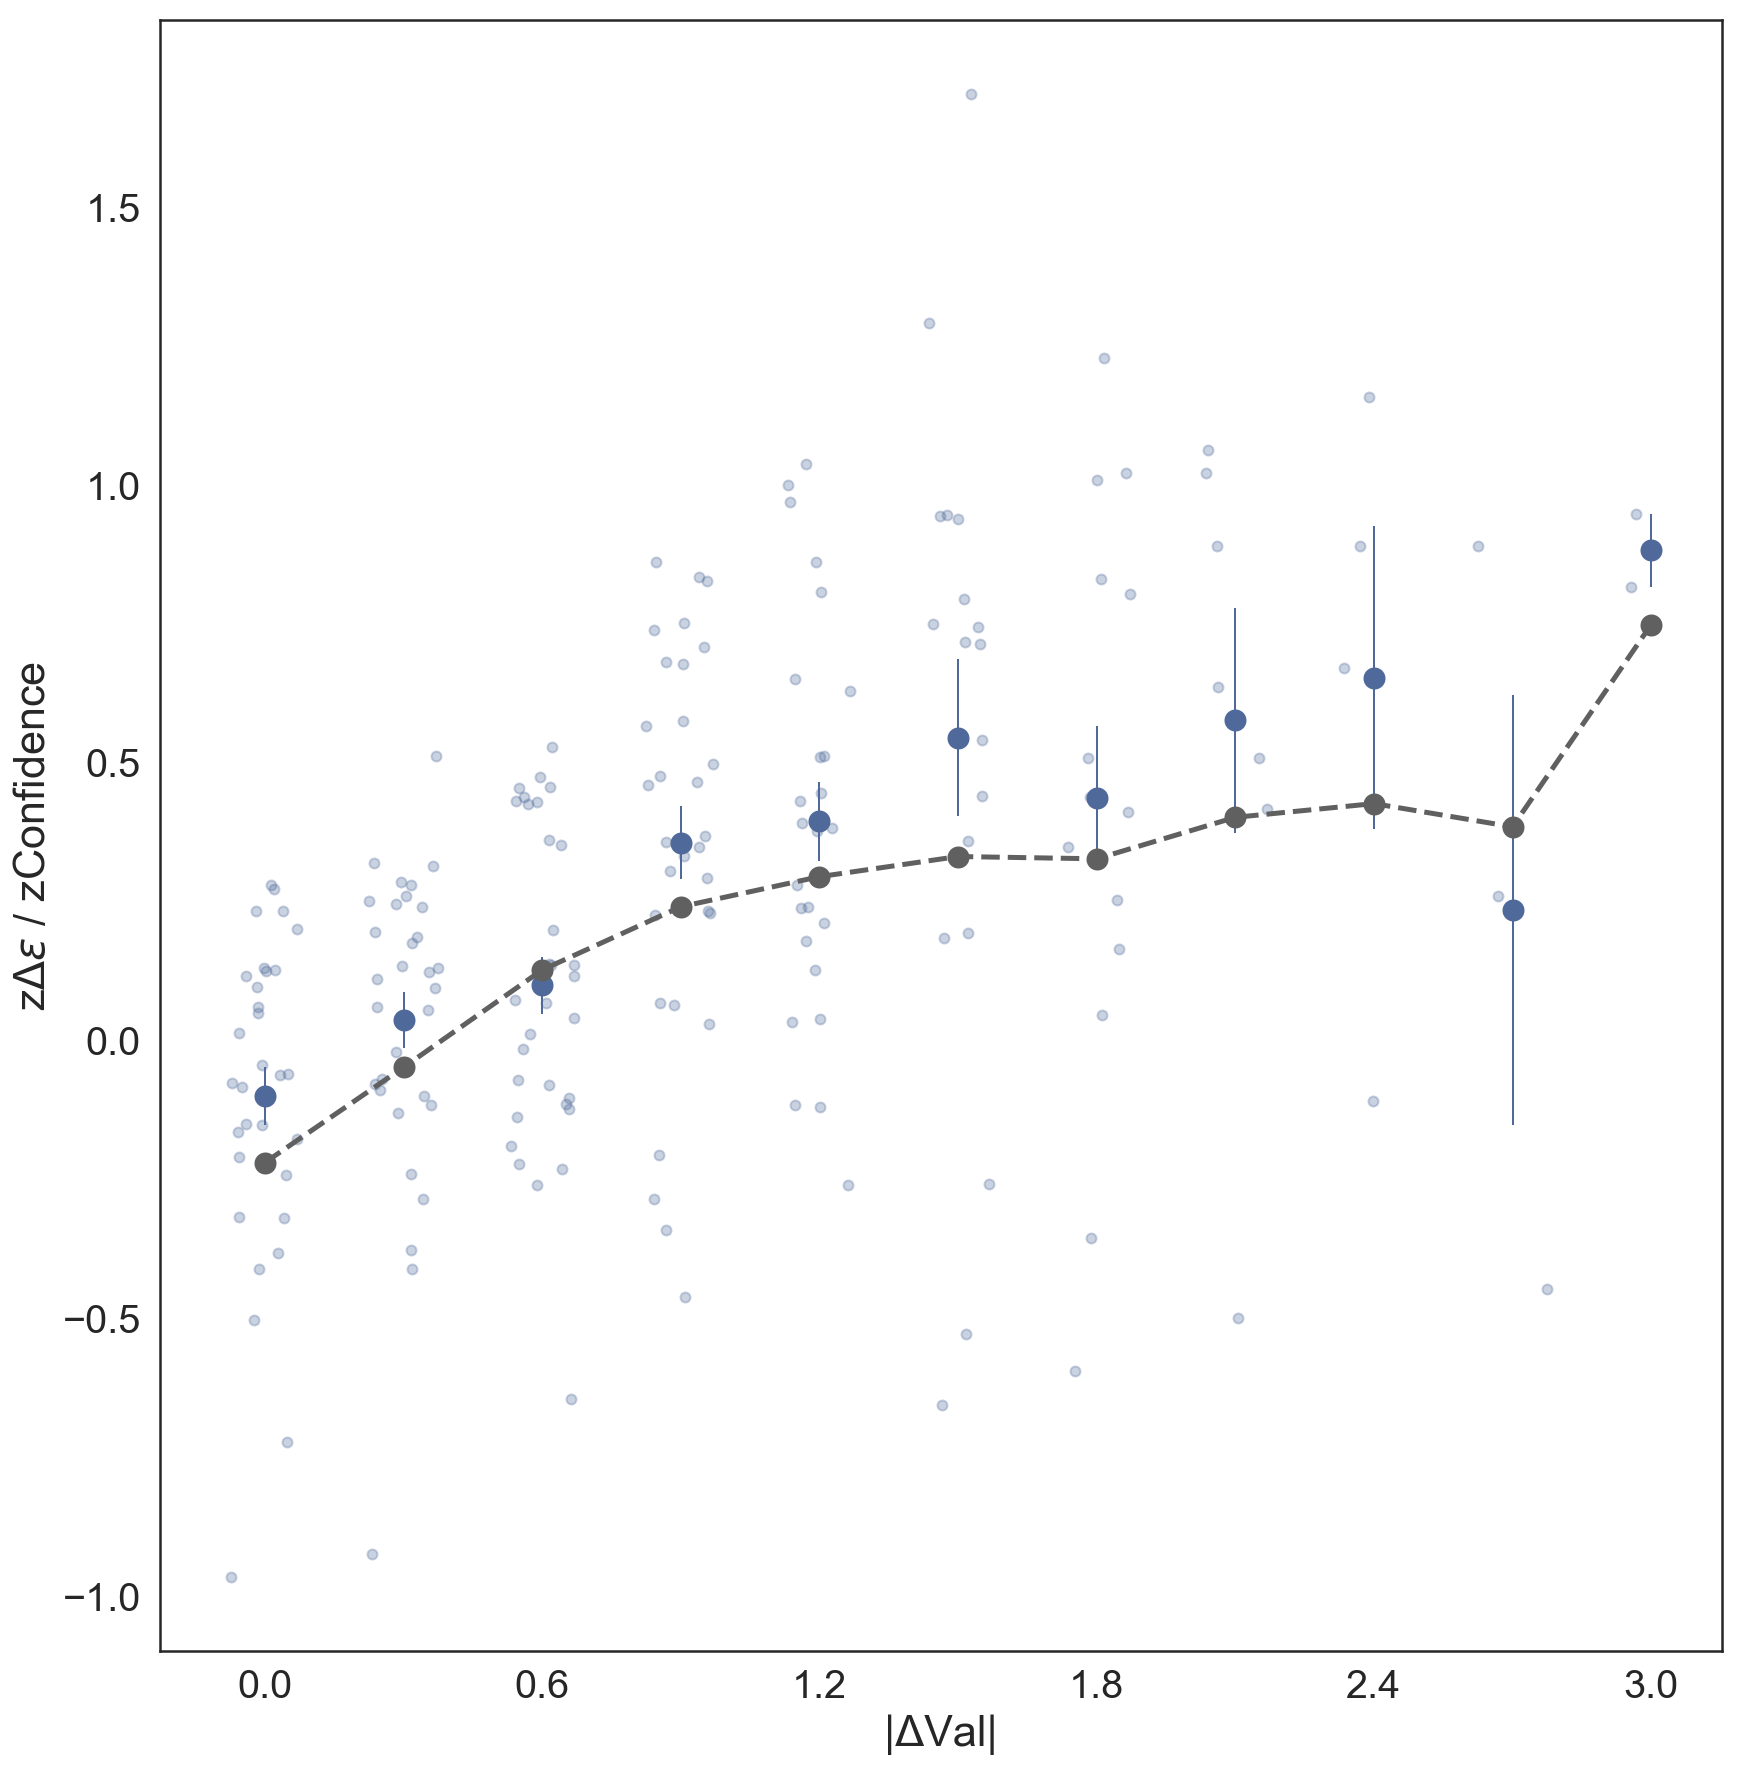

In [29]:
plot_DEv_Conf(data_simulation, xlabel_skip=2,color1 = '#4F6A9A')

Done with TotVal


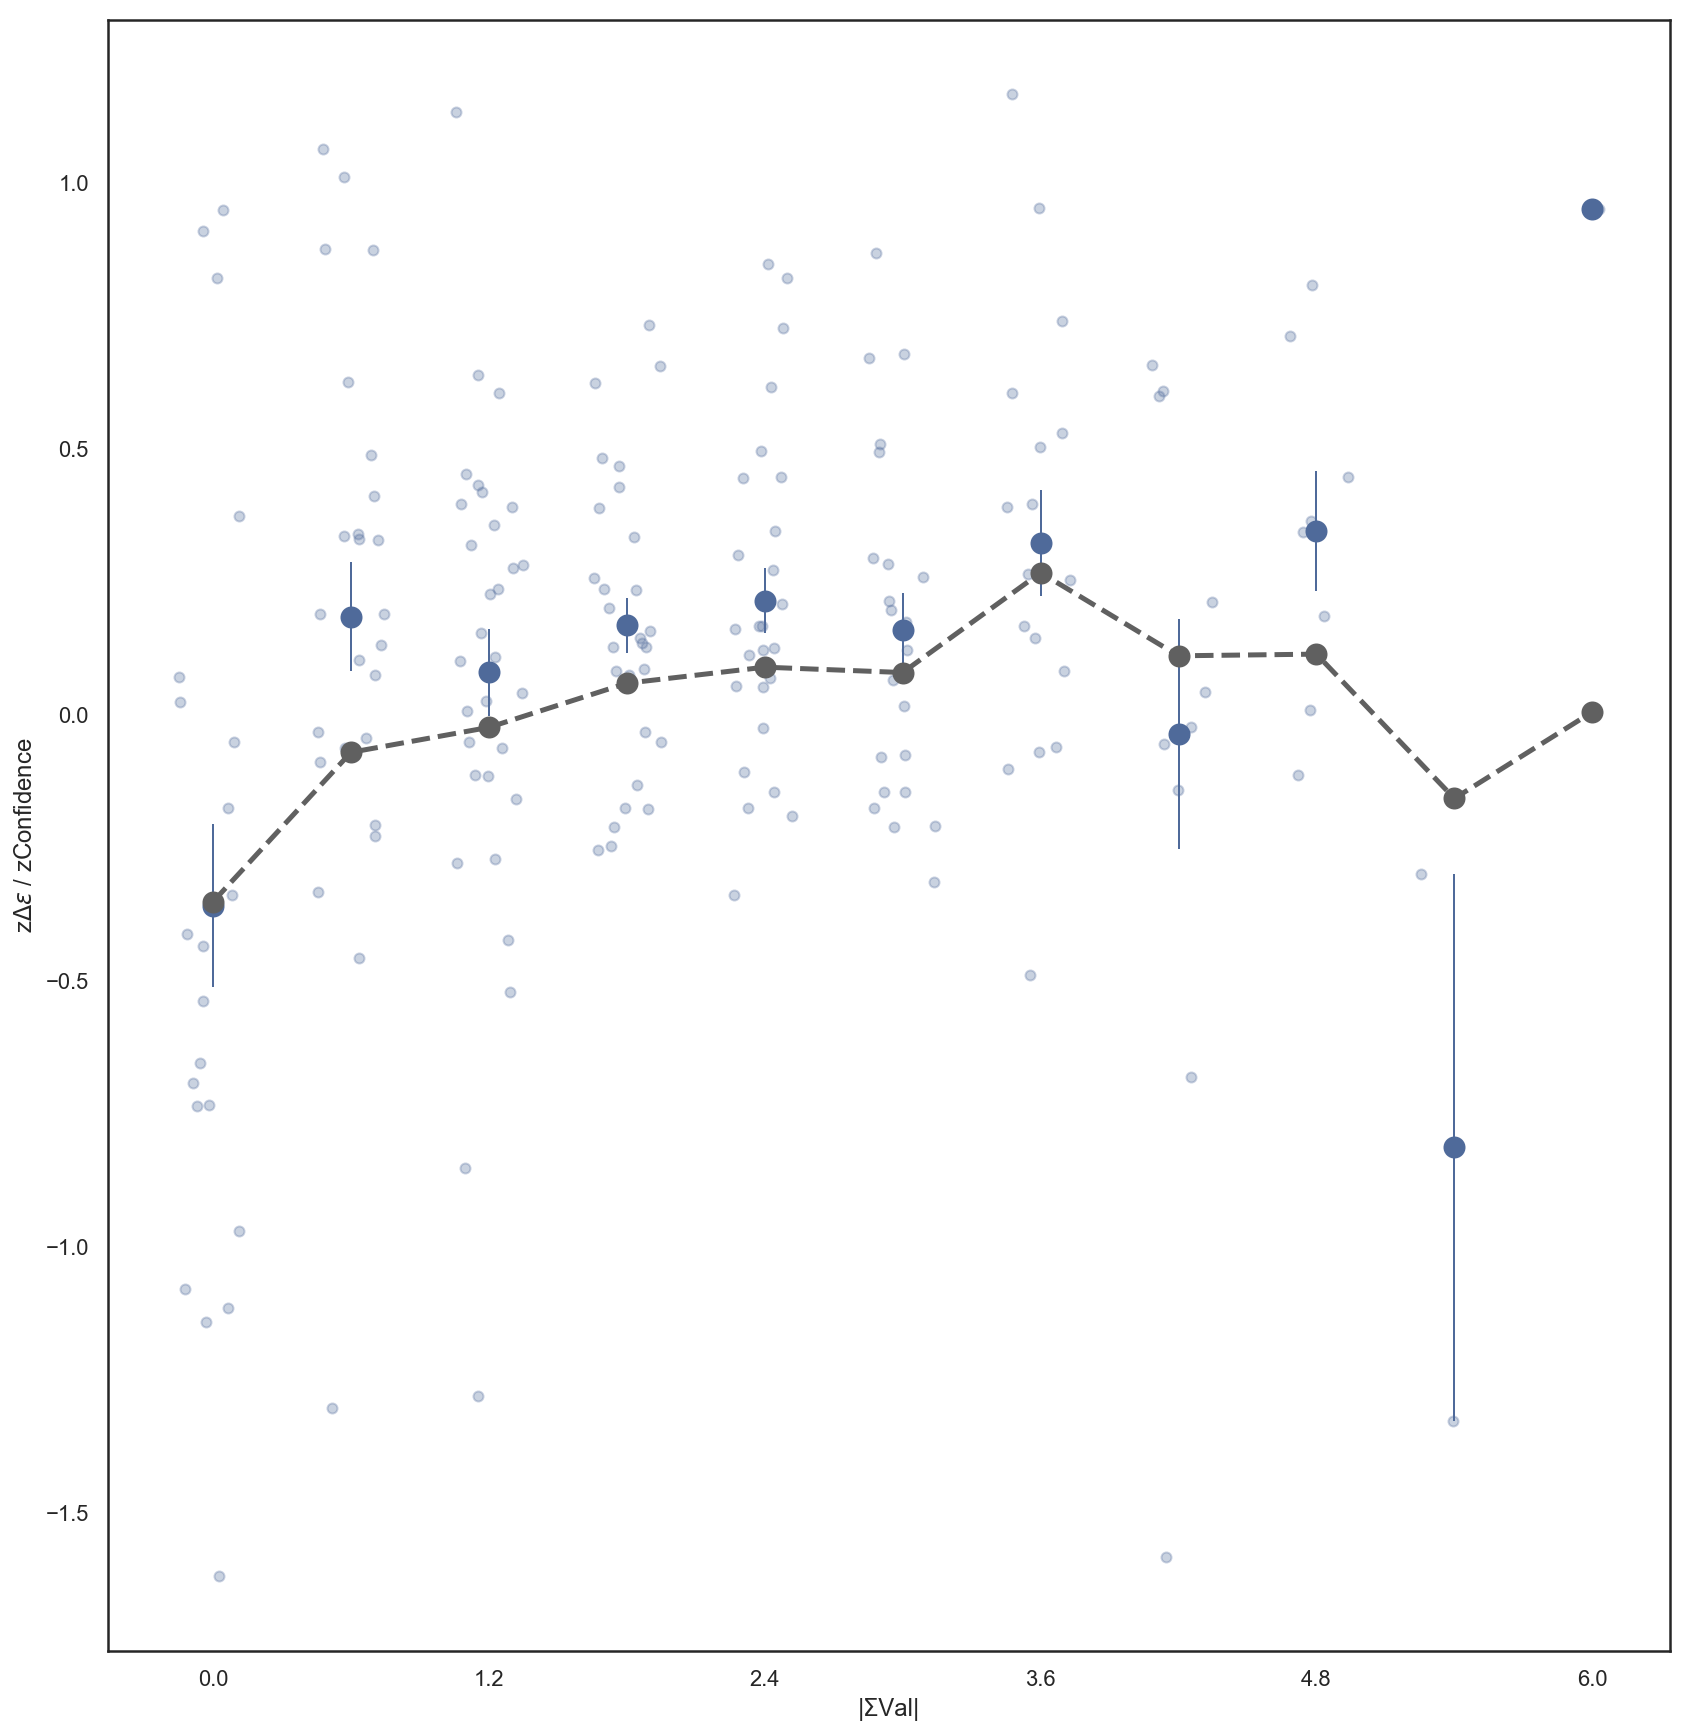

In [30]:
plot_DEv_Conf_TotVal(data_simulation, xlabel_skip=2,color1 = '#4F6A9A')

#  2. Excluding gaze information in the simulation 

In [31]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_like_31_part.csv')):  
        data_simulation2 = pd.read_csv("results/simulations_evidence/DEvidence_simulations_NoGaze_like_31_part.csv")

In [32]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 1 # We DON'T want to use the gaze from the particpants

In [33]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_like_31_part.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    part_id = data_all['Part'].unique()
    
    for i in (data['subject'].unique()):    
        for k in range(0,repeat_extra) :
            PartData = data.loc[data['subject'] == i] # dataframe including participant GLAM data
            PartDataAll = data_all.loc[data_all['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))

    data_simulation2 =  pd.DataFrame()
    
    data_simulation2["Part"] = Part_number
    data_simulation2["LVal"] = LVal
    data_simulation2["RVal"] = RVal
    data_simulation2["AbsDVal"] = absDVal
    data_simulation2["TotVal"] = TotVal
    data_simulation2["AbsDEv"] = AbsDEvid
    data_simulation2["RTsim"] = RT_sim
    data_simulation2["Correct_sim"] = Correct_sim
    data_simulation2["Choice_sim"] = Choice_sim
    data_simulation2["Conf_human"] = Conf_human
    data_simulation2["zConf_human"] = zConf_human
    
    data_simulation2["zLVal"] = z_score1(data_simulation,'Part',"LVal")
    data_simulation2["zRVal"] = z_score1(data_simulation,'Part',"RVal")
    data_simulation2["zAbsDVal"] = z_score1(data_simulation,'Part',"AbsDVal")
    data_simulation2["zTotVal"] = z_score1(data_simulation,'Part',"TotVal")
    data_simulation2["zAbsDEv"] = z_score1(data_simulation,'Part',"AbsDEv")
    data_simulation2["zRTsim"] = z_score1(data_simulation,'Part',"RTsim")

In [34]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_like_31_part.csv')):   
        data_simulation2.to_csv("results/simulations_evidence/DEvidence_simulations_NoGaze_like_31_part.csv")

In [35]:
data_simulation2

,Unnamed: 0,Part,LVal,RVal,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,0,1.10,0.95,0.15,2.05,1.333426,2442.0,0,1.0,80,0.582155,-0.898735,-1.237881,-0.988498,-1.497033,1.878103,-0.321784
1,1,0,2.00,1.70,0.30,3.70,0.430608,4618.0,0,1.0,78,0.432565,1.136137,0.457846,-0.570823,1.116834,-0.673239,1.627372
2,2,0,1.10,2.30,1.20,3.40,0.866234,2401.0,1,1.0,82,0.731746,-0.898735,1.814428,1.935228,0.641585,0.557831,-0.358510
3,3,0,1.25,1.40,0.15,2.65,1.176511,3637.0,1,1.0,42,-2.260059,-0.559590,-0.220445,-0.988498,-0.546536,1.434664,0.748640
4,4,0,2.00,2.30,0.30,4.30,0.740995,2443.0,1,1.0,70,-0.165796,1.136137,1.814428,-0.570823,2.067331,0.203907,-0.320888
5,5,0,1.70,1.85,0.15,3.55,0.743292,1528.0,1,1.0,74,0.133385,0.457846,0.796992,-0.988498,0.879210,0.210399,-1.140501
6,6,0,1.85,0.65,1.20,2.50,0.925937,2075.0,1,0.0,70,-0.165796,0.796992,-1.916172,1.935228,-0.784160,0.726548,-0.650525
7,7,0,1.55,0.80,0.75,2.35,0.803730,1849.0,1,0.0,76,0.282975,0.118701,-1.577026,0.682203,-1.021784,0.381196,-0.852965
8,8,0,1.55,1.10,0.45,2.65,0.973498,1960.0,1,0.0,90,1.330107,0.118701,-0.898735,-0.153148,-0.546536,0.860954,-0.753536
9,9,0,1.10,2.00,0.90,3.10,0.713138,1588.0,1,1.0,54,-1.362518,-0.898735,1.136137,1.099878,0.166337,0.125185,-1.086756


Pearson's r = 0.068 p =  0.0


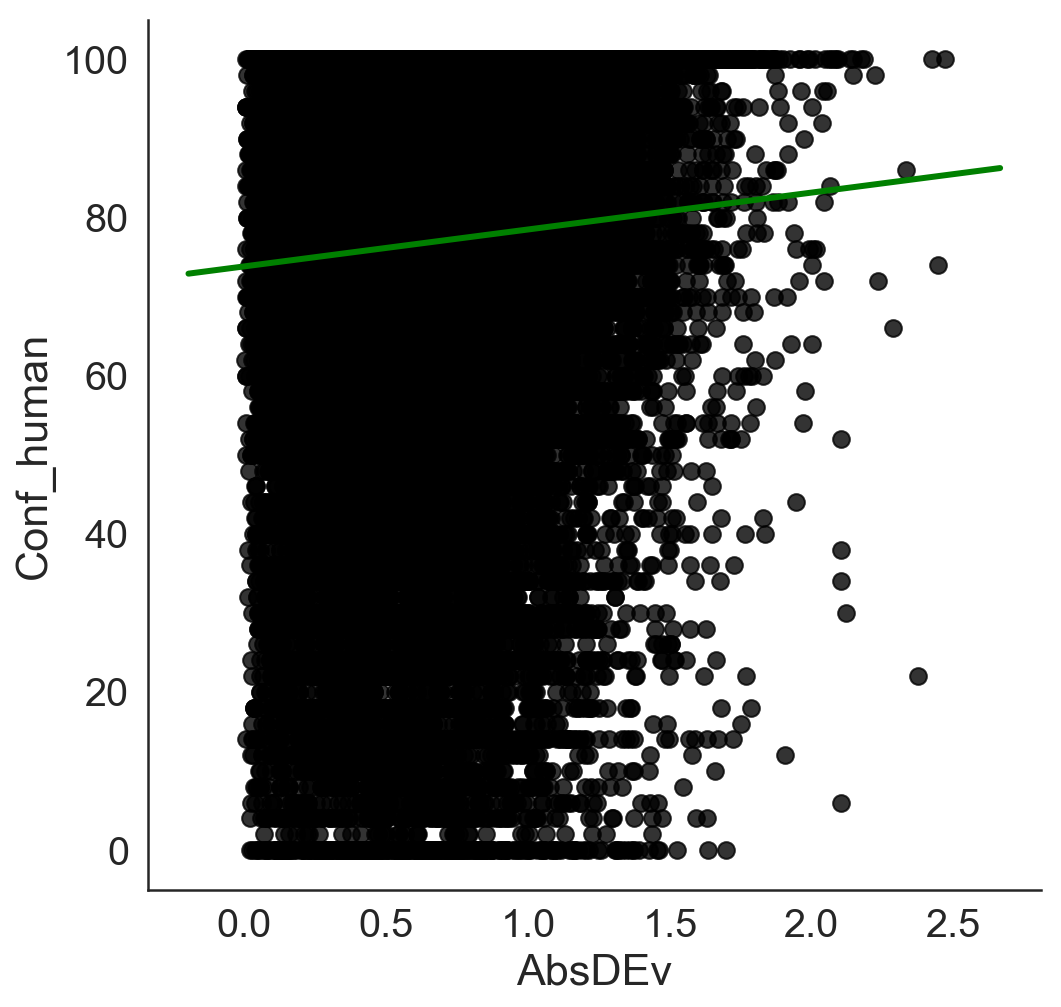

Pearson's r = 0.069 p =  0.0


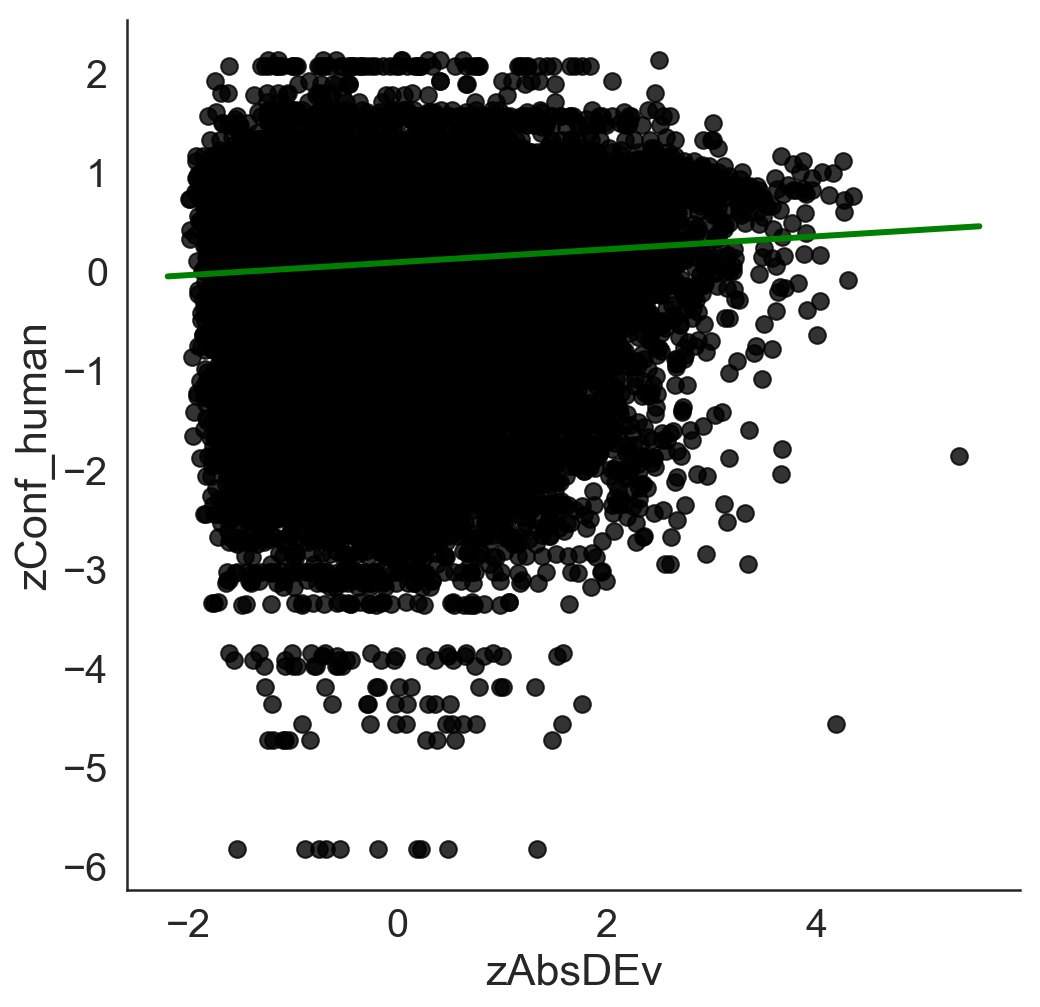

In [36]:
correl_plot(data_simulation2,'AbsDEv', "AbsDEv",'Conf_human','Conf_human')
correl_plot(data_simulation2,'zAbsDEv', "zAbsDEv",'zConf_human','zConf_human')

In [37]:
%%R -i data_simulation2
d <- data_simulation2

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 101798.9
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal + zRTsim, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal       zRTsim  
 -2.001e-16    2.341e-01    3.060e-03   -1.704e-01  

Degrees of Freedom: 37199 Total (i.e. Null);  37196 Residual
Null Deviance:	    37200 
Residual Deviance: 33570 	AIC: 101800


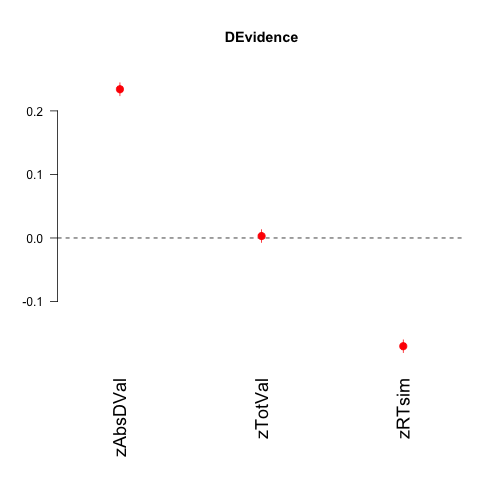

In [38]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

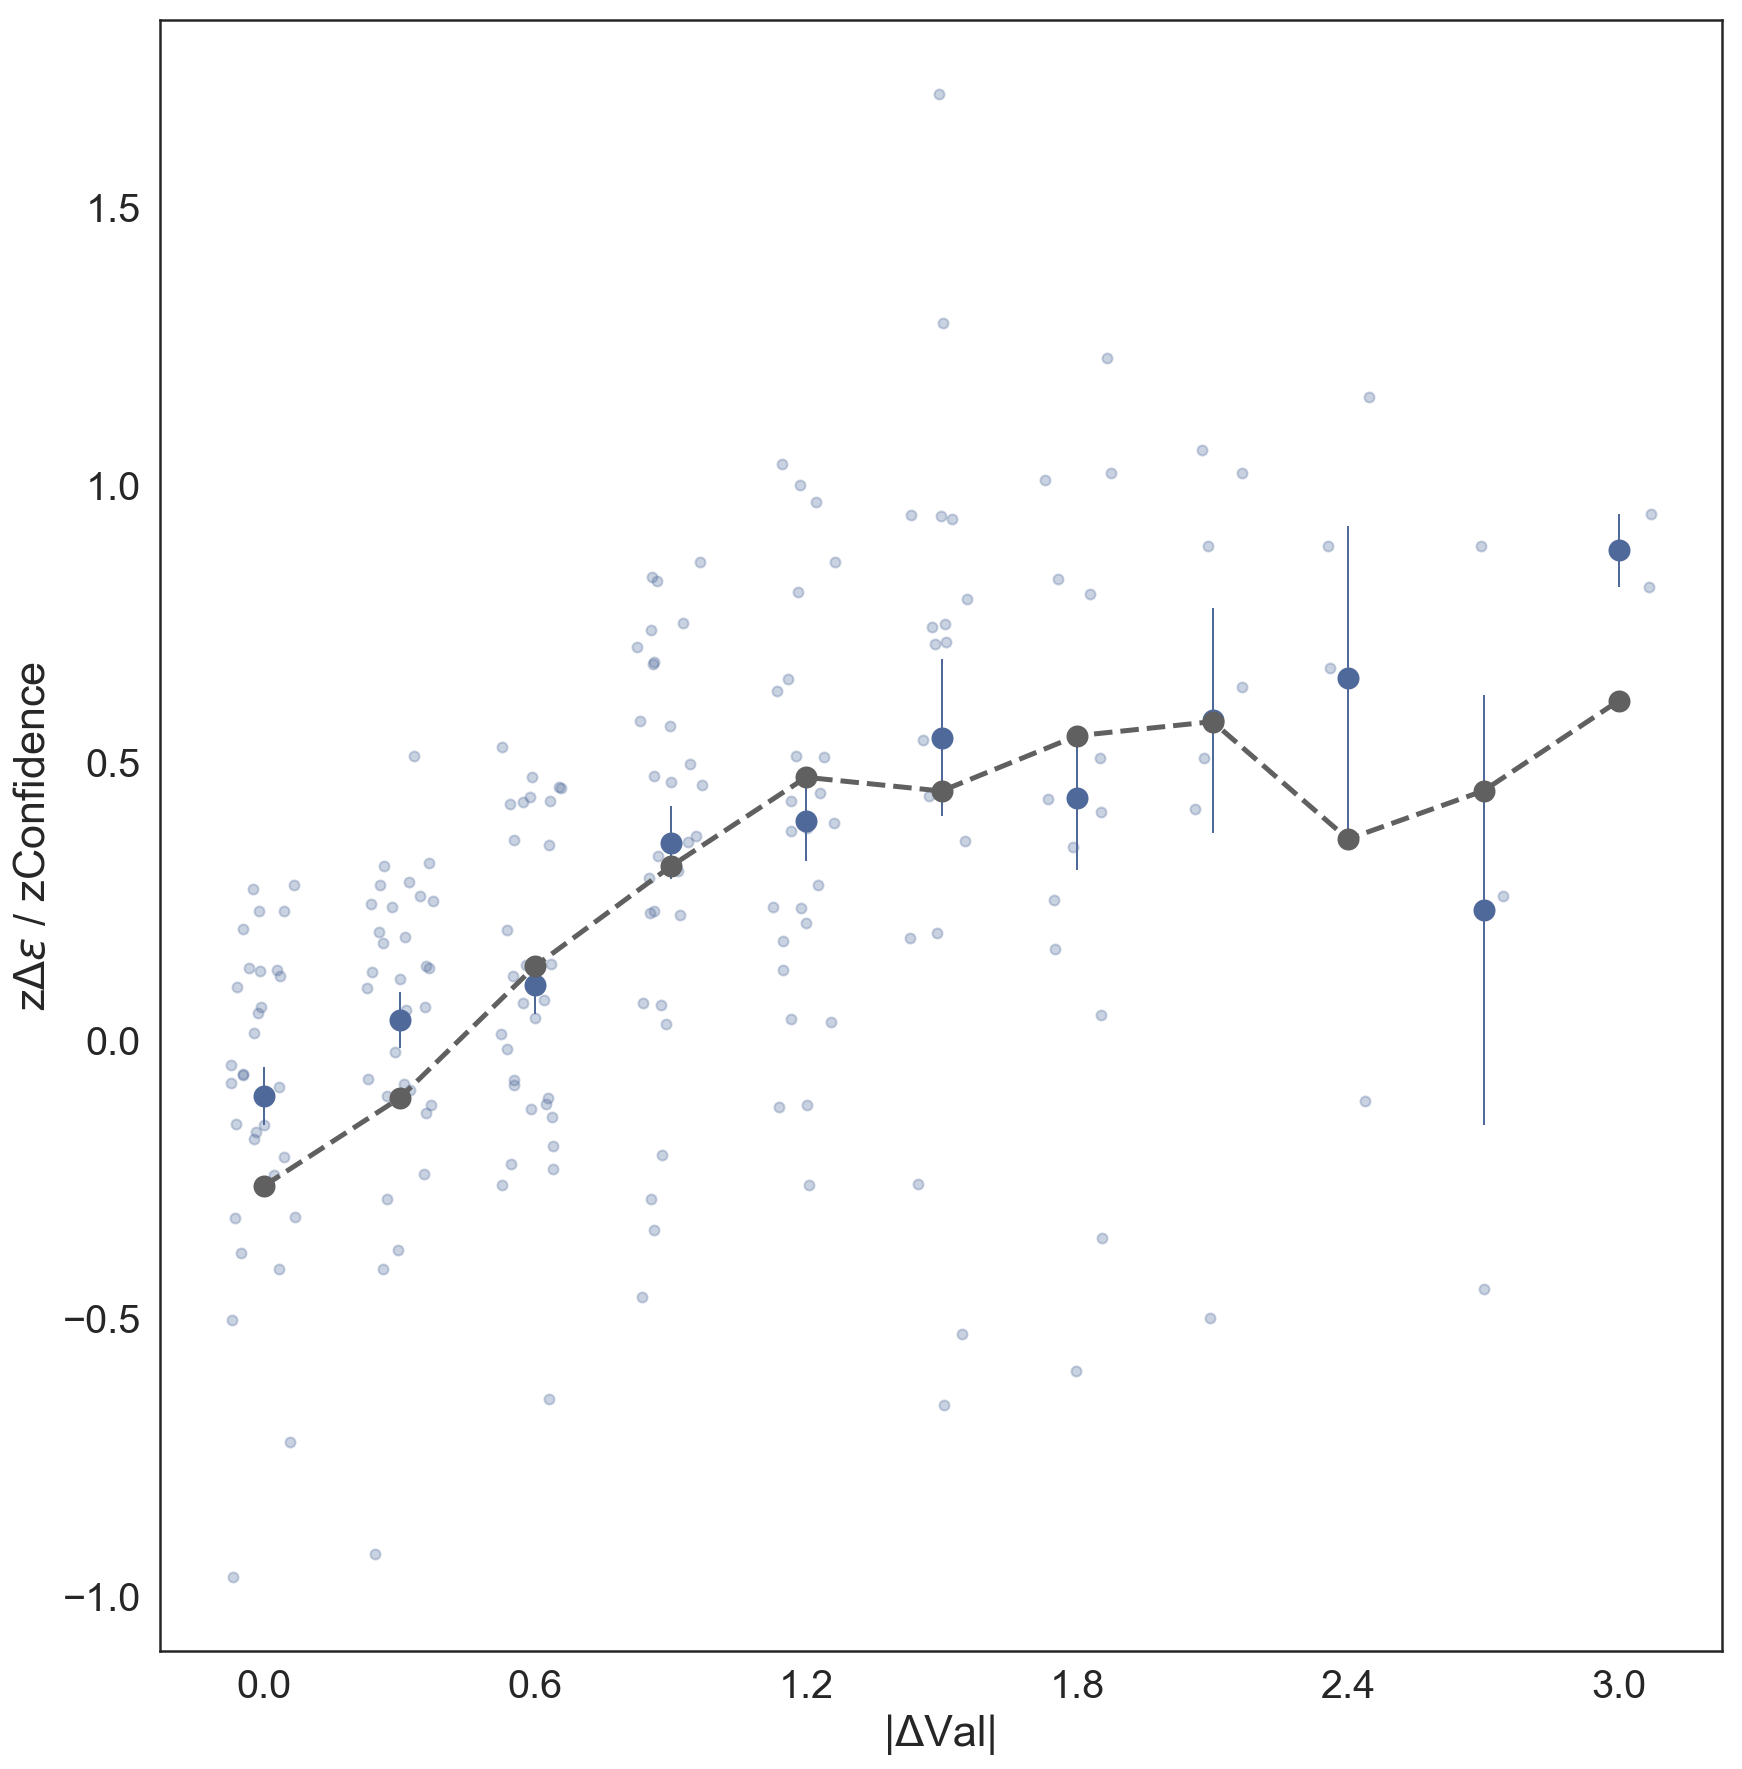

In [39]:
plot_DEv_Conf(data_simulation2, xlabel_skip=2,color1 = '#4F6A9A')

Done with TotVal


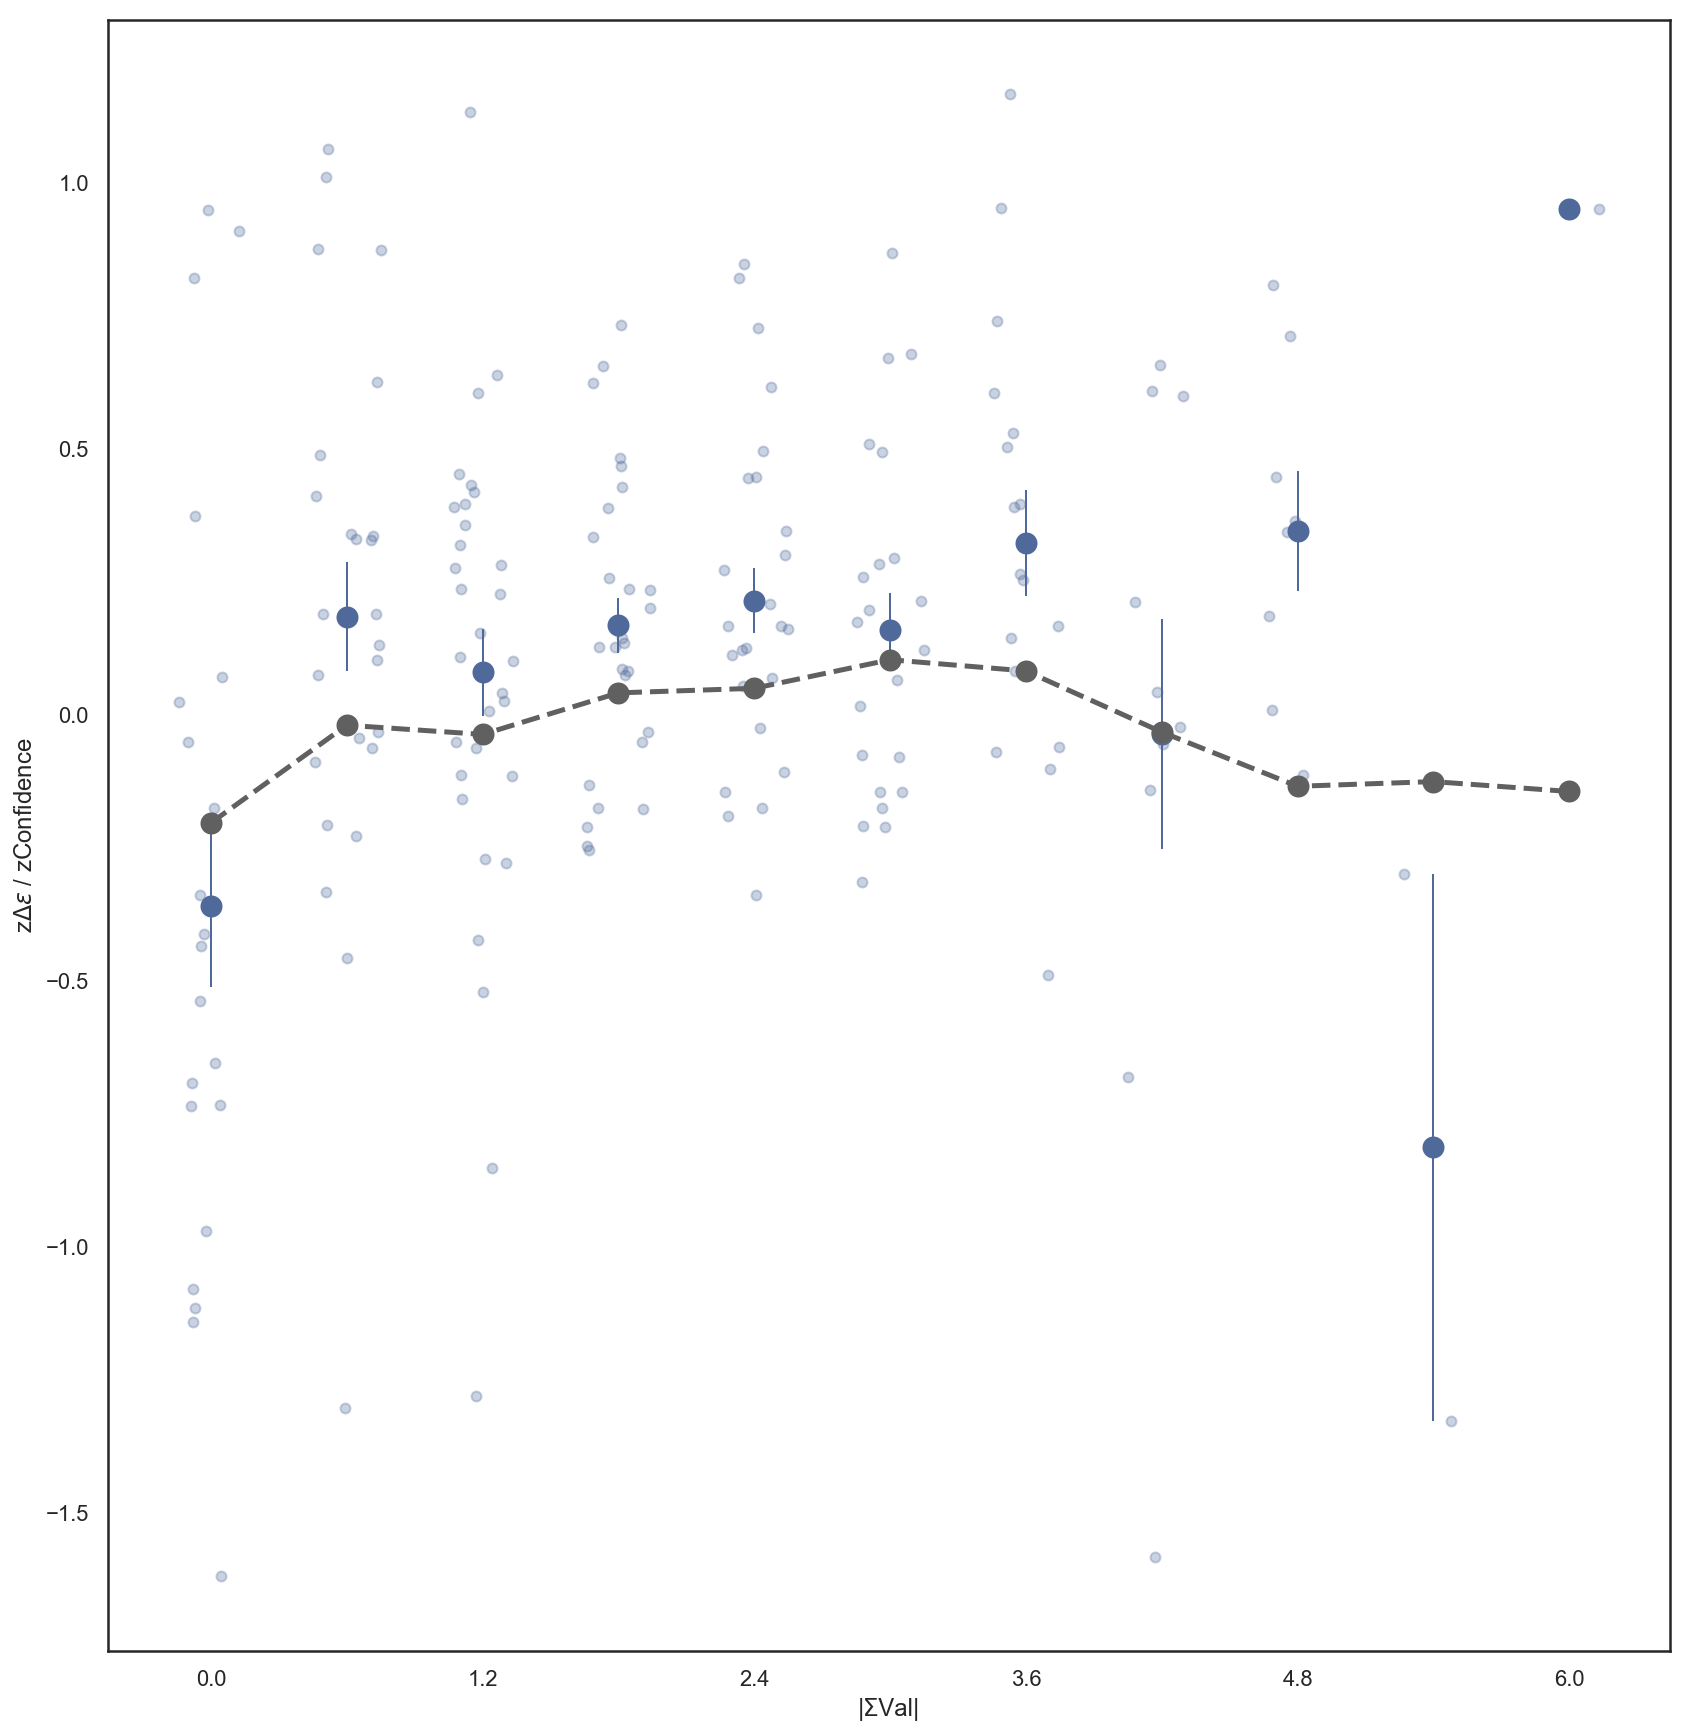

In [40]:
plot_DEv_Conf_TotVal(data_simulation2, xlabel_skip=2,color1 = '#4F6A9A')